# Week 2
The data I am using for analysis comes from https://covid19.galaxyproject.org/genomics/4-Variation/current_complete_ncov_genomes.fasta. This data set contains complete genomes of the SARS-Cov-2 virus. These sequences provided by GalaxyProject are sequences from patients from all over who have contracted SARS-Cov-2. 

In order to be able to use this data in any meaninful way, I needed to first perform multiple sequence alignment on it. Multiple sequence alignment is a way of arranging a biological sequence to help identify regions of similarity, and is done using multiple biological sequences. In order to perform multiple sequence alignment, I used the program virulign from https://github.com/rega-cev/virulign. Multiple sequence alignment of viral genes can be tricky due to the sensitivity to noise in the data many algorithms have; such noise coming from mutations, insertions, and deletions in the sequences. However virulign attempts to overcome some of this sensitivty by allowing for a reference sequence to be used during alignment. This ability to use a reference sequence to guide alignment allows virulign to perform better than more traditional multiple sequence alignent algorithms. Virulign can accept any reference sequence, but also contains reference sequences for various viral genes by default, including sequences for SARS-Cov-2. 

When performing alignment, I decided to use the provided Spike protein sequence as the reference to virulign so the program could use it as a guide when performing the alignment and try to correct for some noise that may be present in my data. The Spike protein sequence was not the only sequence I could have used for reference during alignment of the SARS-Cov-2 genomes. Provided by virulign were many other reference gene sequences for SARS-Cov-2. Although these other sequences were accessible, I decided to focus on utilizing the Spike protein sequence. I did so because since the Spike protein plays a major role in how the virus infects healthy cells, and as such it seemed a good place to start for my analysis. I was also influenced by knowing when analysing SARS-Cov, researchers had success analyzing the Spike protein when trying to determine the origins of the virus. These other reference sequences could be useful for further analysis in the future, however, for the time being I will focus on performing multiple sequence alignment using the reference Spike protein.

Once I had generated the multiple sequence alignments for the sequenced genomes, I used virulign to create a distance matrix for the alignment. I could then use this distance matrix to create phylogenetic trees for the genomes provided by Galaxy Project. To create the trees, I utilized biopython. Since I was able to obtain a distance matrix from virulign, I used this along with biopython to create distance based phylogenetic trees for my data. I could have used biopython to generate the distance matrix as well, however, since virulign was already performing the multiple sequence alignment, I found it easier to have it create the distance matrix as well and then convert it into a biopython distance matrix at run time, which would not require any further calculations

In [ ]:
#Create the distance matrix
!virulign references/SARS-CoV-2/S.xml current_complete_ncov_genomes.fasta --exportAlphabet Nucleotides --exportKind PositionTable > position_table.csv

# Create the multiple sequence alignment
!virulign references/SARS-Cov-2/S.xml current_complete_ncov_genomes.fasta --exportAlphabet Nucleotides --exportKind GlobalAlignment > alignment.fasta

## Distance Tree Construction
Biopython provides two ways of creating a distance based phylogenetic tree using distance matricies; the Neighbor Joining and Unweighted Pair Group Method with Arithmetic Mean (UPGMA) algorithms. Both types of algorithms allow for the construction of phylogenetic trees for both additive and non-additive distance matricies. In order to do so though, I needed to convert the distance matrix computed by virulign into a biopython distance matrix.

In [10]:
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
import pandas as pd
import numpy as np

#Read in the postion table
position_table = pd.read_csv('../../data/position_table.csv')

#Find the distacne from the consensus_sequence for all sequences
concensus_seq = position_table.drop('seqid',axis=1).mode(axis=0).T[0]
position_table = position_table.set_index('seqid')
distance_from_concensus_seq = position_table.apply(lambda row: sum(row != concensus_seq),axis=1)
distance_from_concensus_seq_sorted = distance_from_concensus_seq.sort_values(ascending=False)
subset_seqs = distance_from_concensus_seq_sorted[:10].index

#Construct the distance matrix
distances = {}
for i,seqid1 in enumerate(subset_seqs):
    distances[seqid1,seqid1]=0
    for j in range(i+1,len(subset_seqs)):
        seqid2 = subset_seqs[j]
        distances[seqid1,seqid2] = sum(position_table.loc[seqid1] != position_table.loc[seqid2])
        distances[seqid2,seqid1] = distances[seqid1,seqid2]
distances = pd.Series(distances).unstack()

#Convert to biopython distance matrix
matrix = np.tril(distances.values).tolist()
for i in range(len(matrix)):
    matrix[i] = matrix[i][:i+1]
dm = DistanceMatrix(list(distances.index), matrix)

### Neighbor Joining Tree
For the first tree I created, I used the Neighbor Joining algorithm from biopython. In order to simplify the tree I constructed, I limited the number of sequences used in its construction to the top 10 sequences with the furthest distance from the consensus sequence. In order to find the consensus sequence, I found the most common sequence in the multiple sequence alignment.

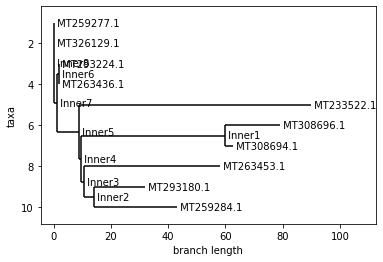

In [11]:
#Construct the NJ tree
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

%matplotlib inline

tree.ladderize()   # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

### UPGMA Tree

The second tree I constructed utilized the UPGMA algorithm provded by biopython. As with the Neighbor Joining tree, I also limited the number of sequences used to only the 10 sequences furthest away from the consensus sequence and used the distance matrix computed using virulign.

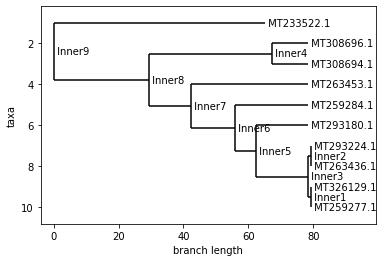

In [12]:
#Construct the UPGMA tree
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

%matplotlib inline

tree.ladderize()   # Flip branches so deeper clades are displayed at top
Phylo.draw(tree)

## Parsimony Tree Construction
After creating distance based phylogenetic trees, I wanted to try creating a Parsimony tree. In order to keep the size of the tree managable, similar to what I did by limiting the number of sequences in the distance based trees, I selected the first 10 sequences in the multiple sequence alignment to create the tree from, selected manually at random; although the sample sequences were from patients from different areas of the world. In order to create the tree, I again utilized bioython, this time using the parsimony tree constructor class. 

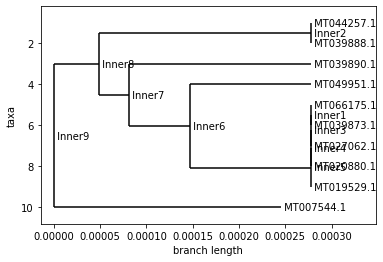

In [13]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import *
aln = AlignIO.read('alignments_cut_down.fasta', 'fasta')
stating_tree = None
scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
constructor = ParsimonyTreeConstructor(searcher)
pars_tree = constructor.build_tree(aln)
Phylo.draw(pars_tree)